# An NLP-powered exploration of financial tweets

_Author : Nicolas Oulianov_

## Introduction

In this notebook, we analyze [a dataset of 28K financial tweets provided by David Wallach](https://www.kaggle.com/davidwallach/financial-tweets/data).  

**The goal of this notebook is to explore the dataset.** That is, to understand _what are the kind_ of tweets in this dataset. 

To do that, we
- encode the tweets using TF-IDF format
- cluster the tweets based on this encoding with K-means
- analyze some well-defined clusters

We find that :
- This model allows us to find relevant tweets about news in the technology sector and market predictions.
- Data collection is flawed : the dataset contains lots of promotional tweets for cryptocurrency exchanges.
- The TF-IDF encoding is susceptible to tweets spamming the same irrelevant keywords. 

We suggest ways to overcome these issues. At the end of this exploration, we gain valuable knowledge to build more robust data collection pipelines and NLP models.

In [57]:
import pandas as pd
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date

## 1. Importing data

Since the data was scrapped from twitter, it's a bit dirty. Some lines are bad. Some characters encodings are wonky. Data augmentation is not perfect. This is to be expected when working with real life data.  

In [29]:
data = pd.read_csv('data/stockerbot-export.csv', sep=',', error_bad_lines=False, parse_dates=True)
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.head(5)

b'Skipping line 3194: expected 8 fields, saw 17\nSkipping line 3205: expected 8 fields, saw 17\nSkipping line 3255: expected 8 fields, saw 17\nSkipping line 3520: expected 8 fields, saw 17\nSkipping line 4078: expected 8 fields, saw 17\nSkipping line 4087: expected 8 fields, saw 17\nSkipping line 4088: expected 8 fields, saw 17\nSkipping line 4499: expected 8 fields, saw 12\n'


id                                               text  \
0  1019696670777503700  VIDEO: ‚ÄúI was in my office. I was minding my o...   
1  1019709091038548000  The price of lumber $LB_F is down 22% since hi...   
2  1019711413798035500  Who says the American Dream is dead? https://t...   
3  1019716662587740200  Barry Silbert is extremely optimistic on bitco...   
4  1019718460287389700  How satellites avoid attacks and space junk wh...   

                  timestamp        source symbols      company_names  \
0 2018-07-18 21:33:26+00:00  GoldmanSachs      GS  The Goldman Sachs   
1 2018-07-18 22:22:47+00:00    StockTwits       M             Macy's   
2 2018-07-18 22:32:01+00:00     TheStreet     AIG           American   
3 2018-07-18 22:52:52+00:00   MarketWatch     BTC            Bitcoin   
4 2018-07-18 23:00:01+00:00        Forbes    ORCL             Oracle   

                                                 url  verified  
0  https://twitter.com/i/web/status/1019696670777...      True  
1  https://twitter.com/i/web/status/1019709091038...      True  
2                            https://buff.ly/2L3kmc4      True  
3  https://twitter.com/i/web/status/1019716662587...      True  
4                     http://on.forbes.com/6013DqDDU      True

In [30]:
print('There are', data.shape[0], 'tweets in the dataset')

There are 28268 tweets in the dataset


## 2. Data visualization

Let's look at the top 15 cited companies. We see that those companies are mostly from the United States. These tweets are most likely to be representative of the American market. 

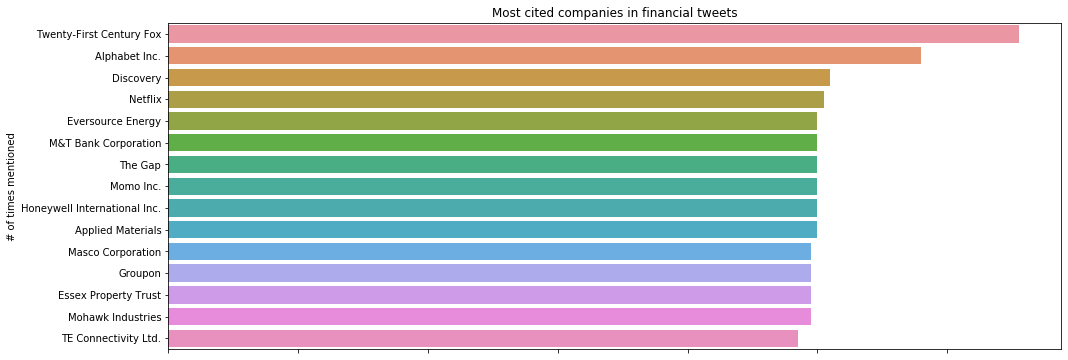

In [164]:
# Top 10 most cited companies
top_cited_companies = data.groupby('company_names').count().sort_values(by='id', ascending=False).reset_index()

def bar_plot(data, x, y, xlabel=None, ylabel="occurences", title=None):
    fig = plt.figure(figsize=(16, 6))
    chart = sns.barplot(data=data, y=y, x=x)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()


bar_plot(data=top_cited_companies.iloc[0:15], x='id', y='company_names', 
         ylabel='# of times mentioned', title='Most cited companies in financial tweets')

Let's now look at the timeframe of the dataset. It is discontinuous. Tweets were mostly collected during 10 consecutive days in July 2018. The majority of tweets were collected on the 18th of July 2018.

This means that we won't to be able to perform, for example, market prediction with these tweets : the timeframe is too narrow. And those tweets are unlikely to be representative of the whole year performance of those companies.

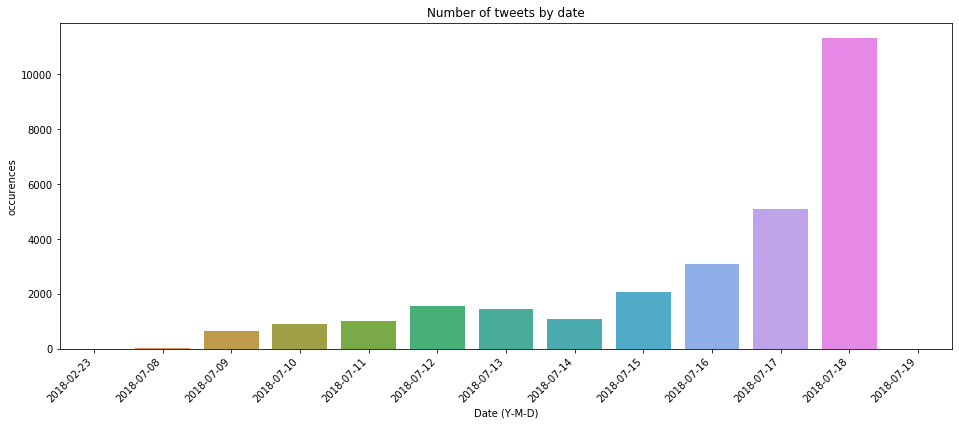

In [32]:
data['y-m-d'] = data['timestamp'].apply(lambda x: '{}-{}-{}'.format(x.year, str(x.month).zfill(2), str(x.day).zfill(2)))
time_data = data.groupby('y-m-d').count().reset_index()#.sort_values(by='timestamp').reset_index()
time_data = time_data.sort_values(by='y-m-d')

bar_plot(data=time_data, x='y-m-d', y='id', 
         xlabel="Date (Y-M-D)", title='Number of tweets by date')

Judging by this, we filter the values to keep only
- companies highly mentionned (>50)
- continuous timeframe (2019-7-9 until 2018-7-18)

In [33]:
data_filtered = data[data['timestamp'].apply(lambda x: x.date()) >= date(2018,7,9)]
highly_mentionned_companies = list(top_cited_companies[top_cited_companies['id'] >= 50]['company_names'])
data_filtered = data_filtered[data_filtered['company_names'].apply(lambda x: x in highly_mentionned_companies)].reset_index()
data_filtered

index                   id  \
0          3  1019716662587740200   
1          8  1019720723441635300   
2          9  1019721145396887600   
3         17  1019729988017377300   
4         21  1019737727477174300   
...      ...                  ...   
24464  28263  1019730088617635800   
24465  28264  1019730115524288500   
24466  28265  1019730115805184000   
24467  28266  1019730117252341800   
24468  28267  1019730146180419600   

                                                    text  \
0      Barry Silbert is extremely optimistic on bitco...   
1      Senate wants emergency alerts to go out throug...   
2      Hedge fund manager Marc Larsy says bitcoin $40...   
3      White House struggles to contain fallout from ...   
4      Templeton and BlackRock say now's the time to ...   
...                                                  ...   
24464         $FB : 29234a9c-7f08-4d5a-985f-cb1a5554ecf9   
24465  „Äê‰ªÆÊÉ≥ÈÄöË≤®„Äë„Éì„ÉÉ„Éà„Ç≥„Ç§„É≥„ÅÆ‰æ°Ê†º‰∏äÊòá„ÄÅÔºòÔºê‰∏áÂÜÜÂè∞ÂõûÂæ©„ÄÄÁ¥ÑÔºë„Ç´ÊúàÂçä„Å∂„Çä„ÄÄ„ÄÄ„ÄÄ„ÄÄ„ÄÄ„ÄÄ$BTC ht...   
24466  RT @invest_in_hd: 'Nuff said!  $TEL #telcoin #...   
24467  „Äê‰ªÆÊÉ≥ÈÄöË≤®„Äë„Éì„ÉÉ„Éà„Ç≥„Ç§„É≥„ÅÆ‰æ°Ê†º‰∏äÊòá„ÄÅÔºòÔºê‰∏áÂÜÜÂè∞ÂõûÂæ©„ÄÄÁ¥ÑÔºë„Ç´ÊúàÂçä„Å∂„Çä„ÄÄ„ÄÄ„ÄÄ„ÄÄ„ÄÄ„ÄÄ$BTC ht...   
24468  Stellar $XLM price: $0.297852 Binance registra...   

                      timestamp           source symbols  \
0     2018-07-18 22:52:52+00:00      MarketWatch     BTC   
1     2018-07-18 23:09:00+00:00       TechCrunch    NFLX   
2     2018-07-18 23:10:41+00:00      MarketWatch     BTC   
3     2018-07-18 23:45:49+00:00          Reuters     UDR   
4     2018-07-19 00:16:34+00:00         business     BLK   
...                         ...              ...     ...   
24464 2018-07-18 23:46:13+00:00       test5f1798      FB   
24465 2018-07-18 23:46:19+00:00  keizai_toushi17     BTC   
24466 2018-07-18 23:46:19+00:00            iad81     BTC   
24467 2018-07-18 23:46:20+00:00  O8viWMyrCV6cBOZ     BTC   
24468 2018-07-18 23:46:27+00:00     Descendent92     AMP   

              company_names  \
0                   Bitcoin   
1                   Netflix   
2                   Bitcoin   
3                       UDR   
4                 BlackRock   
...                     ...   
24464              Facebook   
24465               Bitcoin   
24466               Bitcoin   
24467               Bitcoin   
24468  Ameriprise Financial   

                                                     url  verified       y-m-d  
0      https://twitter.com/i/web/status/1019716662587...      True  2018-07-18  
1                                https://tcrn.ch/2L8DsgT      True  2018-07-18  
2                            https://on.mktw.net/2Ntr7k9      True  2018-07-18  
3                                https://reut.rs/2NrEv8t      True  2018-07-18  
4                               https://bloom.bg/2NmXZLe      True  2018-07-19  
...                                                  ...       ...         ...  
24464                                                NaN     False  2018-07-18  
24465             http://keizai-toushi-navi.com/?p=26838     False  2018-07-18  
24466  https://twitter.com/CRYPTOVERLOAD/status/10178...     False  2018-07-18  
24467         http://true.velvet.jp/monexx/archives/2357     False  2018-07-18  
24468  https://twitter.com/i/web/status/1019730146180...     False  2018-07-18  

[24469 rows x 10 columns]

To better understand the data, we'll perform some basic clustering. In order to do so, we need to first vectorize our data. That is, to transform tweets made from text into vectors made of numbers, that are compatible with clustering algorithms. 

This is what we'll take care of in the following parts.

## 3. Tokenization

We transform a text into a list of tokens (a generalization of _words_ ) using `nltk`. 

In [34]:
import re
import string

In [35]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/haxxor/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/haxxor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [40]:
def remove_punctuation(txt):
    """Returns the string txt without punctuation."""
    return txt.translate(str.maketrans('', '', string.punctuation.replace("'", "") + "‚Äô¬∑‚û°Ô∏è\‚Äú‚Äù‚Ä¶")) 

def preprocess_txt(txt):
    #Remove links
    link_regex = r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?'
    txt = re.sub(link_regex, r'', txt)
    txt = txt.replace("‚Äô", "'")
    #Remove punctuation
    txt = remove_punctuation(txt)
    txt = txt.lower()
    return txt


In order to clean the data and have meaningful tokens, we look at the most frequent tokens. This lets us find out that, for example :

- we need to remove links from tweets
- we need to remove some special punctuation characters

In [41]:
# Frequent tokens
tokens_frequency = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(data_filtered['text'].apply(preprocess_txt))))

In [46]:
df_tokens_frequency = pd.DataFrame.from_dict(tokens_frequency, orient='index').reset_index()
df_tokens_frequency.rename({'index': 'token', 0: 'count'}, axis=1, inplace=True)
df_tokens_frequency = df_tokens_frequency[df_tokens_frequency['token'].apply(lambda x: x not in nltk.corpus.stopwords.words('english'))]
df_tokens_frequency.sort_values(by='count', ascending=False).head(30)

token  count
58           rt   4209
426         inc   3431
171         amp   2313
52           's   1788
185       stock   1613
173    earnings   1607
328       price   1551
597    analysts   1420
377         eps   1185
72           us   1102
12          new   1033
55          buy    965
195       group    955
842      stocks    951
204       today    941
116       short    907
259    expected    899
7016    binance    886
257          co    796
264     million    795
524      rating    765
115     options    760
360      target    757
769        high    743
15589  register    733
393     trading    723
3040       join    718
9374      bonus    714
1203        jul    696
777      energy    696

## 4. Encoding tweets with TF-IDF

As a first way to vectorize our list of tokens, we use the [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) method. This is a classical NLP method to encode tokens, that favours those that are unique to a tweet. 

For the $j$-th tweet, the $i$-th coordinate of the encoded vector will be :

$$w_{j,i} = \text{tf}_{i,j} \times \log_2(\frac{N}{\text{df}_{i}}) $$

Where

- $\text{tf}_{i,j}$ is the number of occurences of token $i$ in tweet $j$
- $\text{df}_{i}$ is the number of tweets containing token $i$
- $N$ is the total number of tweets

This method is simple, but quite powerful when dealing with domain specific linguo, such as in finance.

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer

freq = TfidfVectorizer(preprocessor=preprocess_txt,
                       stop_words=nltk.corpus.stopwords.words('english'),
                      min_df=2) #Keep only tokens with more than 2 occurences

X = freq.fit_transform(data_filtered['text'])

In [65]:
print('Tweets were encoded as a', X.shape[1], 'dimensions sparse vector')

Tweets were encoded as a 13200 dimensions sparse vector


To get a better feel of what our preprocessing chain is doing, let's take a closer look at how the first tweet is encoded. 

Here is the original tweet :

In [66]:
data_filtered['text'].iloc[0]

'Barry Silbert is extremely optimistic on bitcoin -- but predicts that 99% of new crypto entrants are ‚Äúgoing to zero‚Ä¶ https://t.co/mGMVo2cZgY'

Here is it preprocessed and tokenized :

In [69]:
[w for w in preprocess_txt(data_filtered['text'].iloc[0]).split() if w not in nltk.corpus.stopwords.words('english')]

['barry',
 'silbert',
 'extremely',
 'optimistic',
 'bitcoin',
 'predicts',
 '99',
 'new',
 'crypto',
 'entrants',
 'going',
 'zero']

Here is its vectorized representation. Only 10 tokens were frequent enough to be encoded. 

In [70]:
X[0].data # We only show the values that are nonzeros in the sparse vector

array([0.37276159, 0.25814631, 0.21366794, 0.1702604 , 0.32261625,
       0.23714874, 0.37903516, 0.33911773, 0.40724461, 0.36732718])

###  4.1 Visualization with UMAP algorithm

To get a sense of the data repartition, we use the [UMAP algorithm](https://umap-learn.readthedocs.io/en/latest/) to quickly project our data into a 2D plane.

In [91]:
from umap import UMAP

X_umap = UMAP().fit_transform(X)

/home/haxxor/.conda/envs/deep/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../.conda/envs/deep/lib/python3.7/site-packages/umap/sparse.py", line 176:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/home/haxxor/.conda/envs/deep/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 5 separate connected components using meta-embedding (experimental)
  n_components


We plot the output. Each different color correspond to the name of a different company. 

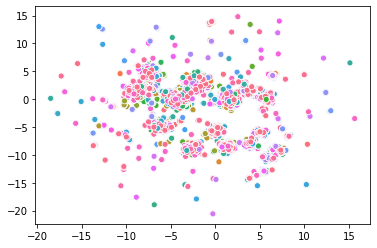

In [92]:
sns.scatterplot(X_umap[:,0], X_umap[:,1], hue=data_filtered['company_names'], legend=None)

What's important about the output of the UMAP algorithm are not the values themselves, since they are meaningless, but how do these values relate to each other. That is, how is the data distributed over the plane.

Here, we see that there is one big central cluster, but also some small clusters all around. **This means that our clustering algorithm is likely to find meaningful clusters in the data.** 

### 4.2 Dimension reduction

A 13,200 vector is great, but it's a bit too much for the computing power we have. The clustering algorithms would take too long to run. This is why we perform dimension reduction. 

In order to reduce dimension while keeping meaningful data, we use the PCA technique. 

In [93]:
from sklearn.decomposition import TruncatedSVD

pca = TruncatedSVD(n_components=500)
X_pca = pca.fit_transform(X)

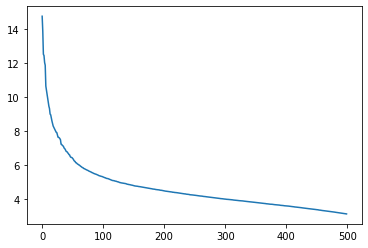

In [96]:
# There is an elbow around the 100-th singular value. 
# This means that we could keep only the first 100th value for data to be representative
sns.lineplot(data=pca.singular_values_)

In [129]:
# We tried clustering using only the first 100-th coordinates. But we were dissatisfied with the results.
# So we use the whole 500 coordinates. 
X_reduced = X_pca#[:,:100]

## 5. Clustering using K-Means

### 5.1 K parameter selection using elbow method

To pick the k (number of clusters) in the K-means algorithm, we use the elbow method. That is, we pick a k such has increasing k doesn't lower loss _that much_. 

In [130]:
from sklearn.cluster import KMeans

losses = []
k_parameters = list(range(1,30))

for k in k_parameters:
    kmean = KMeans(n_clusters=k, max_iter=6000, n_jobs=4)
    kmean.fit(X_reduced)
    losses.append(- kmean.score(X_reduced))

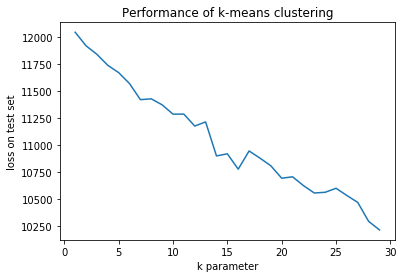

In [133]:
plt.plot(k_parameters, losses)
plt.xlabel('k parameter')
plt.ylabel('loss on test set')
plt.title('Performance of k-means clustering')
plt.show()

According to the graph above, `k=14` is the best. 

In [134]:
kmean = KMeans(n_clusters=14, max_iter=6000, n_jobs=4)
kmean.fit(X_reduced)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=6000,
       n_clusters=14, n_init=10, n_jobs=4, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

### 5.2 Cluster analysis

Looking at the cluster repartition below, we see, as expected, one big cluster with more than 10,000 tweets (more than 50% of the dataset), and a few smaller ones. We don't expected this large cluster to be especially meaningful, so we'll look more into the others. 

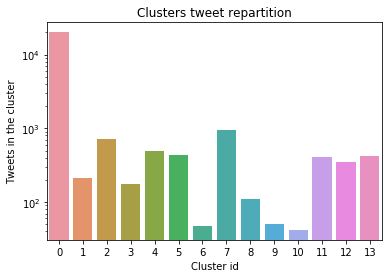

In [144]:
c_predicted = kmean.predict(X_reduced)
classes, classes_count = np.unique(c_predicted, return_counts=True)

sns.barplot(classes, classes_count)
plt.yscale('log')
plt.ylabel('Tweets in the cluster')
plt.xlabel('Cluster id')
plt.title('Clusters tweet repartition')
plt.show()

#### 5.2.1 Cluster 7 : Financial news about the technology market

Let's start with the cluster 7. Looking at the mot frequent tokens, we see many symbols for big American tech companies : Amazon, Facebook, Netflix, Apple, Google, Microsoft, Tesla, Cisco, Alibaba... These tweets, we assume, are mostly about the innovative technology sector. 

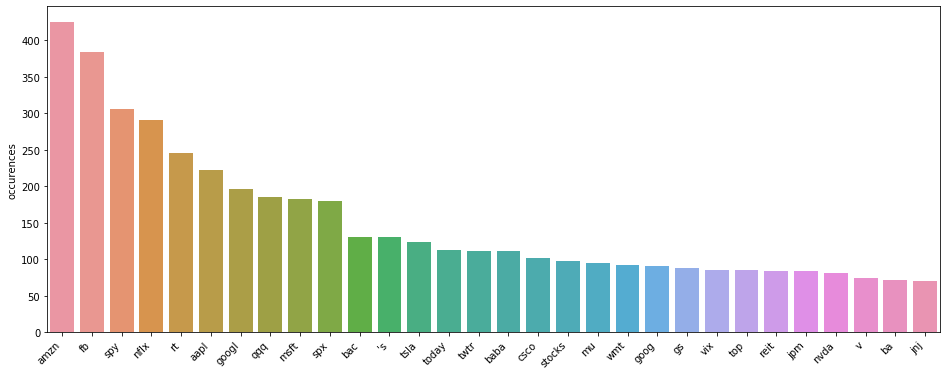

In [165]:
def get_most_frequent_tokens(data_text):
    tokens_frequency = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(data_text.apply(preprocess_txt))))
    df_tokens_frequency = pd.DataFrame.from_dict(tokens_frequency, orient='index').reset_index()
    df_tokens_frequency.rename({'index': 'token', 0: 'count'}, axis=1, inplace=True)
    df_tokens_frequency = df_tokens_frequency[df_tokens_frequency['token'].apply(lambda x: x not in nltk.corpus.stopwords.words('english'))]
    df_tokens_frequency = df_tokens_frequency.sort_values(by='count', ascending=False).head(30)
    return df_tokens_frequency

bar_plot(get_most_frequent_tokens(data_filtered.iloc[c_predicted==7]['text']), 'token', 'count')

#### 5.2.2 Cluster 2 : Promotional tweets & spam detection

Looking at cluster number 2, we see something radically different in the most frequent tokens : 
- marketing terms : register, bonus, discount, sign, fee, trade today, get one, join...
- emojis implying wealth and success
- cryptocurrencies references : binance, crypto, exchange, bitmex, trades...

We guess that these must be a cluster of promotional tweets for Cryptocurrencies trading platforms. These aren't directly related to financial news and wouldn't be expected in "Financial tweets". 

In some applications, we would like to get rid of those. This can be done by better data collection. For example, by filtering out all the tweets that are predicted to be in cluster 2 by our model. 

In [167]:
get_most_frequent_tokens(data_filtered.iloc[c_predicted==2]['text'])

token  count
12    register    667
14       bonus    659
4      binance    466
2       crypto    232
8     discount    213
9      trading    208
74    exchange    204
54        sign    195
7           50    183
10         fee    175
63       trade    164
83       today    119
6          get    108
48         one     95
77        join     91
67      bitmex     91
89           üôå     87
22           ü§î     87
43           ü§ë     83
57           üíé     78
73     growing     77
58           üí∞     77
72     fastest     77
29           üòç     76
82      trades     76
116          üöÄ     76
42           üí∏     73
11           üòä     70
78          us     67
86   discounts     63

#### 5.2.3 Cluster 13 : Tweets about forecasting the market

On tweeter, many analysts share their forecasting about stocks. Cluster 13 is filled with those predictions, as future-specific tokens show it : expected, post, announce, anticipate, expect, estimated, forecasts, forecasted...

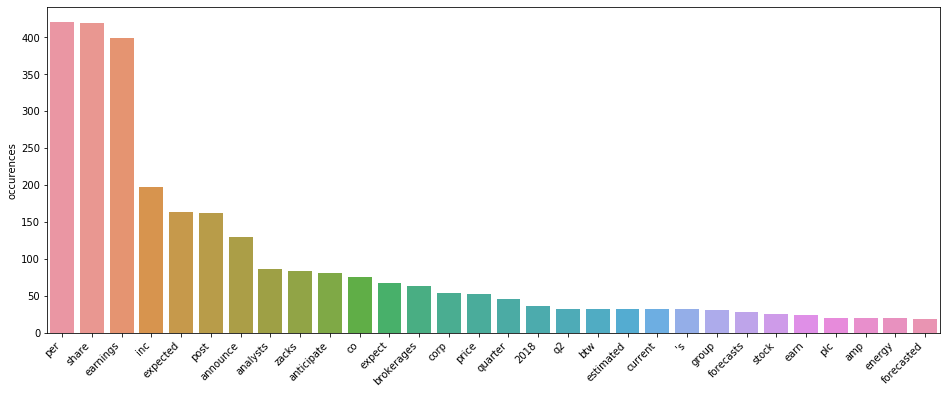

In [168]:
bar_plot(get_most_frequent_tokens(data_filtered.iloc[c_predicted==13]['text']), 'token', 'count')

#### 5.2.4 Cluster 11 : Limits of TF-IDF

Cluster 11 is interesting to look into as it highlights the issues with the TF-IDF data encoding. Indeed, the 3 most frequent tokens are : Zacks Investment Research. This is a [Financial research company](https://www.zacks.com). 

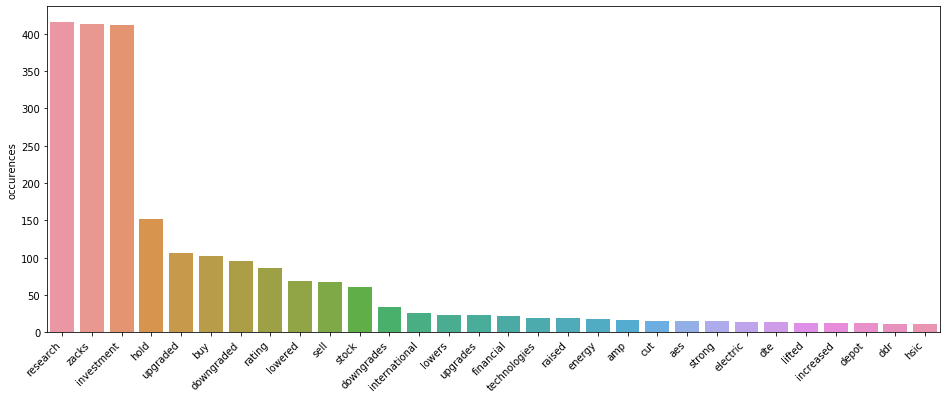

In [169]:
bar_plot(get_most_frequent_tokens(data_filtered.iloc[c_predicted==11]['text']), 'token', 'count')

Looking into the tweets, we see that those 3 keywords are featured constantly in the tweets. 

In [156]:
data_filtered.iloc[c_predicted==11]['text']

73       Zacks Investment Research Upgrades Torchmark $...
74       Zacks Investment Research Upgrades Torchmark $...
81       Stericycle $SRCL Stock Rating Upgraded by Zack...
82       Stericycle $SRCL Lifted to ‚ÄúBuy‚Äù at Zacks Inve...
665      Torchmark $TMK Upgraded at Zacks Investment Re...
                               ...                        
20746    Cisco Systems $CSCO Downgraded to ‚ÄúHold‚Äù at Za...
20902    Zacks Investment Research Lowers Tractor Suppl...
20921    TJX Companies $TJX Stock Rating Upgraded by Za...
20934    Zacks Investment Research Lowers Tractor Suppl...
20936    Zacks Investment Research Lowers Tractor Suppl...
Name: text, Length: 415, dtype: object

In other words, here our model ditch in this cluster every tweet featuring keywords "Zacks investment research". This is due to our way of encoding tokens into vectors. "Zacks investment research" is rare enough so that it scores high on TF-IDF.

This is not a behaviour we'd like : we'd want the model to be most interested in companies those tweets are about. 

To solve this issue we could filter out the words "Zacks investment research" in our preprocessing, or look into a more complex encoding of data. 

## 6. Conclusion

At the end of this data exploration, we found that :
- Our model allows us to find relevant tweets about news in the technology sector and market predictions.
- Data collection is flawed : the dataset contains lots of promotional tweets for cryptocurrency exchanges.
- The TF-IDF encoding is susceptible to tweets spamming the same irrelevant keywords. 

We suggested ways to overcome these issues. Overall, we gained some valuable knowledge about data collection pipelines and building NLP models for tweets. This data exploration was fruitful !